# ML model for Keyword Classification
This notebook introduces (1) how we explore, prepare and preprocess the datasets; (2) how we train and evaluate the ML model; and (3) how we use this trained ML model.
## Problem Formalisation
### Preliminaries
The AODN catalogue $C=\{M, K, P\}$ serves as a platform for storing datasets and their associated metadata. $M=\{m_1,m_2,\ldots, m_x\}$ is a set of metadata records which are used to describe the dataset in AODN catalogue $C$. $K=\{k_1, k_2, \ldots, k_y\}$ is a set of pre-defined keywords that are used to categorise dataset. $P=\{p_1, p_2, \ldots, p_n\}$ is a set of pre-defined parameters used to describe the attributes of raw data.

- **Definition 1: A metadata $m_i=(d_i, K_i, P_i), m_i \in M$** is a record describing a dataset. Specifically, $i$ is the unique identifier of the record. $d_i$ is a textual abstract that serves as the description of the dataset. $K_i \subseteq K$ is a subset of keywords used to label the dataset. $P_i \subseteq P$ is a subset of parameters used to describe the attributes of the raw data in the dataset.

- **Definition 2: A description $d_i$** is the textual abstract of a metadata, which is used to describe the dataset in a plain text way. $\mathbf{d_i}$ is the embedding representation of the textual description $d_i$. We used 'BERT' to calculate the description embedding $\mathbf{d_i}$ for each description $d_i$.

- **Definition 3: A keyword matrix $\mathbf{K}$** is a pre-defined textual label, which is be used to categorise datasets.$X \times Y$ binary matrix, where $X=|M|$ is the size of the metadata records set $M=\{m_1,m_2,\ldots, m_x\}$, and $Y=|K|$ is the size of the keywords set $K=\{k_1, k_2, \ldots, k_y\}$. Each entry $ \mathbf{K}[i, j] $ is 1 if metadata record $ m_i $ is associated with keyword $ k_j $, and 0 otherwise.
### Problem Description
In the catalogue $C = \{M, K, P\}$, a subset of metadata records, $M_t \subseteq M$, have not yet been categorised with keywords. For these records, $K_i = \emptyset $ for all $m_i \in M_t$. Given another subset of metadata records, $M_s \subseteq M$, where each record has already been categorised with keywords (i.e., $K_i \neq \emptyset $ for all $m_i \in M_s$). The research question is as follows:

How to design and develop a machine learning model, denoted as $MM_{keywords}$, that can automatically label the uncategorised metadata records $M_t$ using a predefined set of keywords $K$. Specifically, the model should be trained to learn a mapping rule $d_i \mapsto K_i$ based on the observed patterns from the labelled metadata records $M_s$, where each description $d_i$ of a metadata record $m_i \in M_s$ is associated with a set of keywords $K_i$. Once trained, the model should be able to apply this learned mapping to accurately categorise the records in $M_t$ by assigning their corresponding keywords based on the records' descriptions.

To simplify the task, we restrict the scope of keywords to those falling within the primary AODN vocabularies:

- ~~AODN Organisation Vocabulary~~
- ~~AODN Instrument Vocabulary~~
- AODN Discovery Parameter Vocabulary
- ~~AODN Platform Vocabulary~~
- ~~AODN Parameter Category Vocabulary~~

Only keywords $k_j \in K_i$ that are part of the listed AODN vocabularies will be considered. Any keyword not belonging to these vocabularies will be excluded from $K_i$ for all metadata records in the categorised metadata set $M_s$.

## Explore Datasets
The datasets are preprocessed as sample set $M_s$, and target set $M_t$, we can explore these sets before we preprocess it. In target set, there are **1075** records missing keywords field. In sample set, there are **1588** records with keywords falls in 'AODN Discovery Parameter Vocabulary'. Note there might be more labels (keywords) for these records, but we only keep an eye on this vocabulary.

In [1]:
from utils.preprocessor import load_datasets
targetDS, sampleDS, K = load_datasets()

c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
targetDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1075 non-null   object 
 1   title        1075 non-null   object 
 2   description  1075 non-null   object 
 3   keywords     0 non-null      float64
 4   embedding    1075 non-null   object 
dtypes: float64(1), object(4)
memory usage: 42.1+ KB


In [3]:
sampleDS

,id,title,description,keywords,embedding
0,52b58d9a-a0b4-4396-be8e-a9e5e2b493f0,IMOS SOOP Underway Data from AIMS Vessel RV So...,'Ships of Opportunity' (SOOP) is a facility of...,"[Practical salinity of the water body, Turbidi...","[-0.57627493, -0.52038336, 0.14258689, -0.0053..."
1,52c92036-cea9-4b1a-b4f0-cc94b8b5df98,IMOS - SRS - SST - L3C - NOAA 19 - 3 day - day...,"This is a single sensor, multiple swath SSTski...",[Skin temperature of the water body],"[-0.7428907, -0.006864315, 0.20524804, -0.6074..."
2,52e8e882-5108-4295-b336-e97c11af7ad4,Sea Water Temperature Logger Data at Taure Ree...,This data set was collected by one or more tem...,"[Depth of observation or sample collection, Te...","[-0.36630422, -0.2719815, 0.26079246, -0.06611..."
3,52f09a23-63a2-4c14-8b3b-1fc7c8167281,IMOS - ACORN - Turquoise Coast HF ocean radar ...,The Turquoise Coast (TURQ) HF ocean radar syst...,"[Northward current velocity in the water body,...","[-1.013301, -0.28140602, 0.2872767, -0.2471972..."
4,533bba87-bd26-4bb6-91a4-613d104ae310,Square Rocks Air Pressure From 19 Dec 2009,This data set was collected by weather sensors...,[Pressure (measured variable) exerted by the a...,"[-0.47256887, -0.26229754, 0.35784346, -0.1494..."
...,...,...,...,...,...
1583,ff50ae2f-0f79-4eaa-806c-8954ab0e545b,One Tree Island Air Pressure From 18 Nov 2008 ...,The 'Wireless Sensor Networks Facility' (forme...,[Pressure (measured variable) exerted by the a...,"[-0.31585604, -0.34964982, -0.014602914, -0.05..."
1584,fed52ea8-bde9-4126-aa3d-69431fce5694,Port Curtis Integrated Monitoring Program - PC...,This data set was collected by sensors deploye...,"[Total Organic Carbon Sediment, KD Water Quali...","[-0.5563927, -0.6243812, 0.3688077, -0.1797219..."
1585,fcd7a039-2134-4761-ad08-ec42b8e05610,IMOS SOOP Underway Data from AIMS Vessel RV So...,'Ships of Opportunity' (SOOP) is a facility of...,"[Practical salinity of the water body, Turbidi...","[-0.57493657, -0.5267085, 0.12662068, -0.01271..."
1586,fbe4dbce-3435-48df-a054-f0e399886e2b,IMOS - SRS - SST - L3S - Single Sensor - 14 da...,This is a multi-sensor SSTskin product for fou...,[Skin temperature of the water body],"[-0.8789551, -0.2196846, 0.28057387, -0.572204..."


In [4]:
sampleDS

,id,title,description,keywords,embedding
0,52b58d9a-a0b4-4396-be8e-a9e5e2b493f0,IMOS SOOP Underway Data from AIMS Vessel RV So...,'Ships of Opportunity' (SOOP) is a facility of...,"[Practical salinity of the water body, Turbidi...","[-0.57627493, -0.52038336, 0.14258689, -0.0053..."
1,52c92036-cea9-4b1a-b4f0-cc94b8b5df98,IMOS - SRS - SST - L3C - NOAA 19 - 3 day - day...,"This is a single sensor, multiple swath SSTski...",[Skin temperature of the water body],"[-0.7428907, -0.006864315, 0.20524804, -0.6074..."
2,52e8e882-5108-4295-b336-e97c11af7ad4,Sea Water Temperature Logger Data at Taure Ree...,This data set was collected by one or more tem...,"[Depth of observation or sample collection, Te...","[-0.36630422, -0.2719815, 0.26079246, -0.06611..."
3,52f09a23-63a2-4c14-8b3b-1fc7c8167281,IMOS - ACORN - Turquoise Coast HF ocean radar ...,The Turquoise Coast (TURQ) HF ocean radar syst...,"[Northward current velocity in the water body,...","[-1.013301, -0.28140602, 0.2872767, -0.2471972..."
4,533bba87-bd26-4bb6-91a4-613d104ae310,Square Rocks Air Pressure From 19 Dec 2009,This data set was collected by weather sensors...,[Pressure (measured variable) exerted by the a...,"[-0.47256887, -0.26229754, 0.35784346, -0.1494..."
...,...,...,...,...,...
1583,ff50ae2f-0f79-4eaa-806c-8954ab0e545b,One Tree Island Air Pressure From 18 Nov 2008 ...,The 'Wireless Sensor Networks Facility' (forme...,[Pressure (measured variable) exerted by the a...,"[-0.31585604, -0.34964982, -0.014602914, -0.05..."
1584,fed52ea8-bde9-4126-aa3d-69431fce5694,Port Curtis Integrated Monitoring Program - PC...,This data set was collected by sensors deploye...,"[Total Organic Carbon Sediment, KD Water Quali...","[-0.5563927, -0.6243812, 0.3688077, -0.1797219..."
1585,fcd7a039-2134-4761-ad08-ec42b8e05610,IMOS SOOP Underway Data from AIMS Vessel RV So...,'Ships of Opportunity' (SOOP) is a facility of...,"[Practical salinity of the water body, Turbidi...","[-0.57493657, -0.5267085, 0.12662068, -0.01271..."
1586,fbe4dbce-3435-48df-a054-f0e399886e2b,IMOS - SRS - SST - L3S - Single Sensor - 14 da...,This is a multi-sensor SSTskin product for fou...,[Skin temperature of the water body],"[-0.8789551, -0.2196846, 0.28057387, -0.572204..."


K is the keyword binary matrix for the records in sample set

In [5]:
K

,Abundance of biota,Accelerometer data,Acoustic signal return amplitude from the water body,Aluminium Bioaccumulation,Aluminium Dissolved Water Quality,Aluminium Total Water Quality,Ammonia-N Physicochemistry,Amplicon,Animal-borne video,Antarctic Bottom Water,...,net_downward_shortwave_flux_in_air,pH,pH (total scale) of the water body,particulate iron data quality flag,potential temperature,surface_albedo,the maximum potential quantum efficiency of Photosystem II,upwelling_longwave_flux_in_air,upwelling_shortwave_flux_in_air,voltage
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,0,0,0,0,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Look into this $K$ matrix, we can investigate the keyword distribution of the sample set

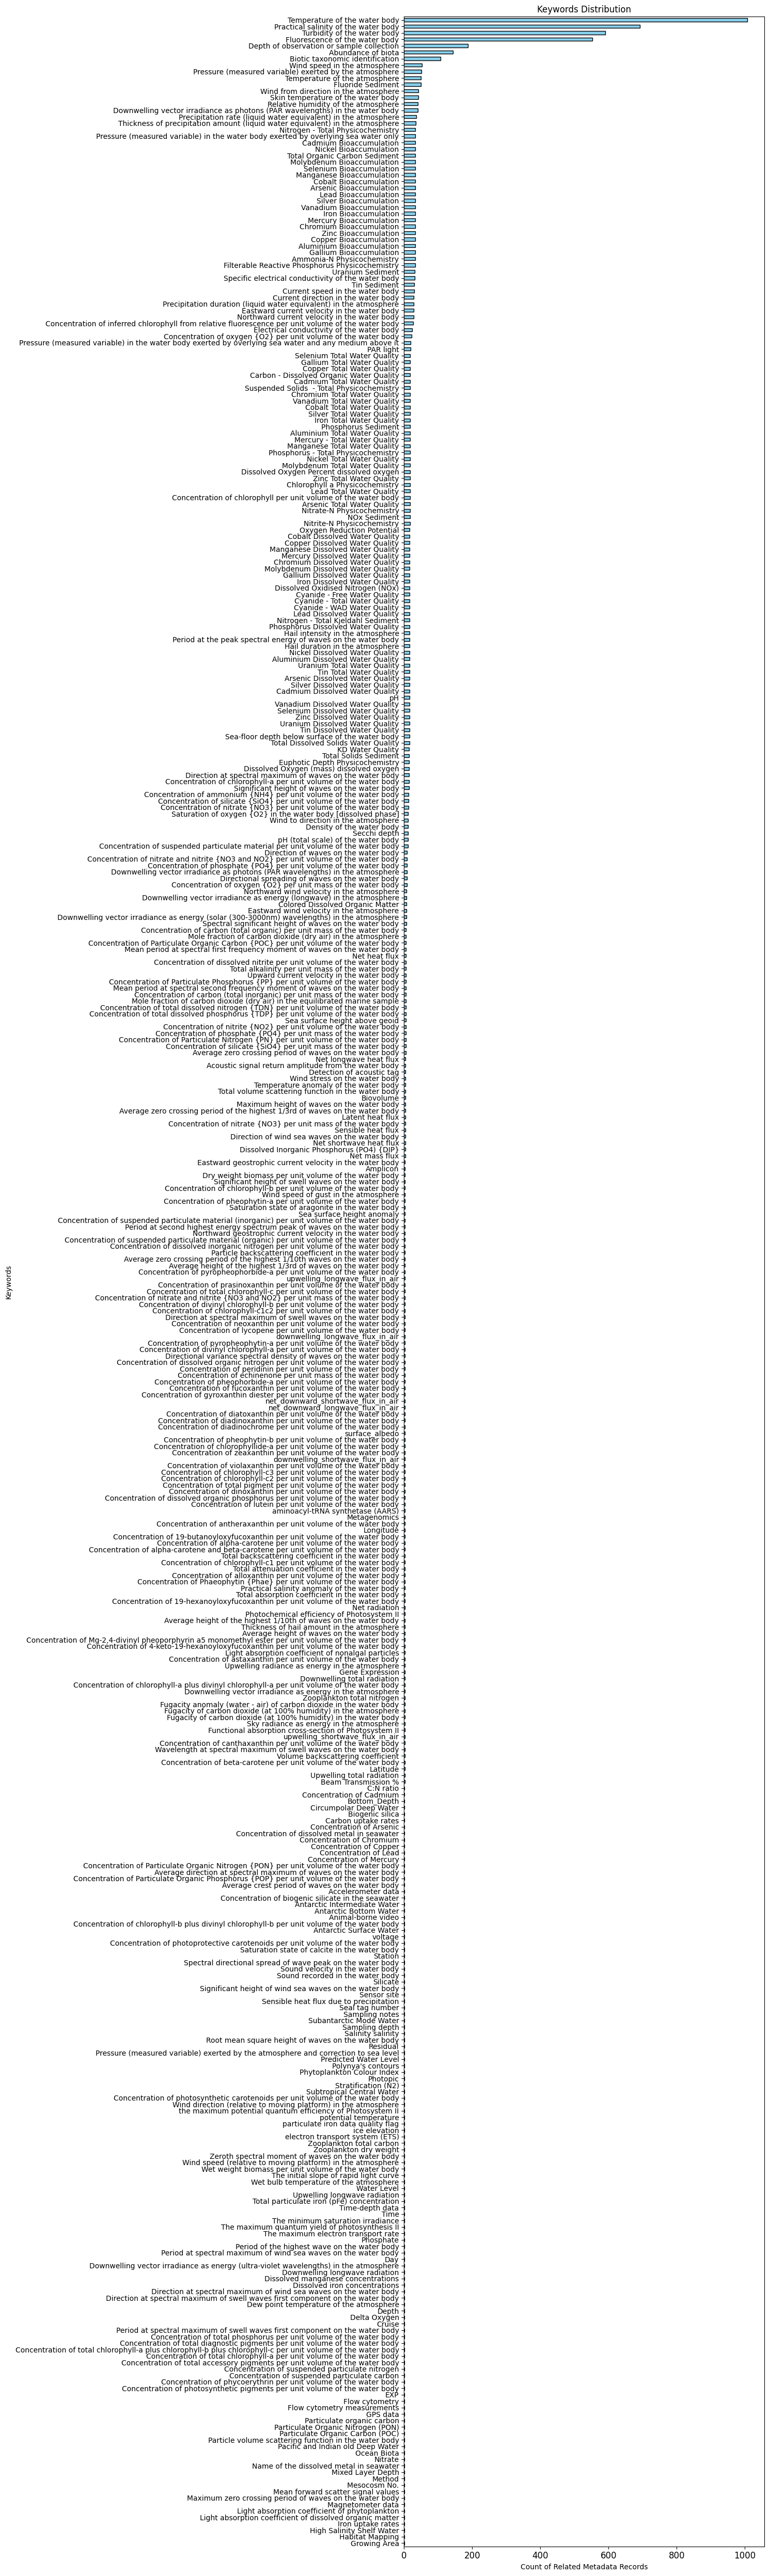

In [6]:
from matplotlib import pyplot as plt

keyword_distribution = K.copy()
keyword_distribution = keyword_distribution.sum()

plt.figure(figsize=(15,50))
keyword_distribution.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Keywords Distribution")
plt.ylabel("Keywords")
plt.xlabel("Count of Related Metadata Records")
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [9]:
count_K = K.copy()
count_K['Keyword Count'] = K.sum(axis=1)

print(f"Average number of keywords each record has: {count_K['Keyword Count'].mean()}")
print(f"Maximum number of keywords a record has: {count_K['Keyword Count'].max()}")
print(f"Minium number of keywords a record has: {count_K['Keyword Count'].min()}")


Average number of keywords each record has: 4.1379093198992445
Maximum number of keywords a record has: 66
Minium number of keywords a record has: 0


In [11]:
keyword_distribution_df = keyword_distribution.to_frame(name='count')
keyword_distribution_df

,count
Abundance of biota,144
Accelerometer data,1
Acoustic signal return amplitude from the water body,4
Aluminium Bioaccumulation,32
Aluminium Dissolved Water Quality,16
...,...
surface_albedo,2
the maximum potential quantum efficiency of Photosystem II,1
upwelling_longwave_flux_in_air,2
upwelling_shortwave_flux_in_air,2


Based on our statistical analysis, we identified several key challenges in this multi-label classification task:

- **Global Label Imbalance**: The distribution of keywords across the dataset is highly imbalanced. While a few metadata records are associated with a large number of keywords (up to 66), many records are linked with only a small number of keywords (as few as 1). This significant variation poses difficulties for the model to accurately learn and predict the diverse label distributions.

- **Internal Label Imbalance**: Within each metadata record, there is also a strong imbalance between positive and negative labels. Despite having a total of 393 unique labels, each record is typically annotated with only a small subset of these labels, averaging around 4.14 keywords per record. This means that for any given record, the number of positive labels is relatively small compared to the number of negative labels, which can hinder the model's ability to effectively identify less frequently occurring keywords.

Keep these challenges in mind, we focus on the **Keyword Classification** Task. That is, predict keywords (from 'AODN Discovery Parameter Vocabulary') for metadata records.